<b> Import Library, find available devices </b>

In [105]:
# Initialization code for 1.8 V SiGe PMOS LDO Testing. 
# Primarily written by Langdon for NPN_LVR, adapted by Shawn for PMOS_LDO
# This block identifies and initializes the connected SMUs (Source Measure Units).

import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
import csv                       # Read from and write to CSV files
from datetime import date        # Read current date
from collections import defaultdict

In [ ]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

<b> Connect devices <b>

In [ ]:
# If running for the first time, ensure the equipment names are correctly referenced

#Establishing Connection for VIN SMU
SM_VIN = rm.open_resource('GPIB6::20::INSTR')  # Open a connection to the instrument with the address 'ASRL3::INSTR' and assign it to SM_VIN
SM_VIN.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
SM_VIN.write_termination = '\n'            # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
SM_VIN.baud_rate = 9600                    # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
print(SM_VIN)                              # Print the resource object (SM_VIN) to display its properties
print(SM_VIN.query('*IDN?'))               # Send the '*IDN?' command to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).

#Establishing Connection for VOUT multimeter
MM_VOUT = rm.open_resource('USB0::10893::257::MY57508183::0::INSTR')
MM_VOUT.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM_VOUT.write_termination = '\n'
MM_VOUT.baud_rate = 9600
print(MM_VOUT)                             # Display resource's properties
print(MM_VOUT.query('*IDN?'))

#Establishing Connection for multimeter 1
MM_VDROP = rm.open_resource('USB0::0x2A8D::0x0101::MY54505624::INSTR')
MM_VDROP.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM_VDROP.write_termination = '\n'
MM_VDROP.baud_rate = 9600
print(MM_VDROP)                             # Display resource's properties
print(MM_VDROP.query('*IDN?'))              

#Establishing Connection for VREF waveform generator
WG = rm.open_resource('USB0::2391::22279::MY53802060::0::INSTR')
WG.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
WG.write_termination = '\n'
WG.baud_rate = 9600
print(WG)                             # Display resource's properties
print(WG.query('*IDN?'))

#Establishing Connection for Temperature Chamber
CHAMBER = rm.open_resource('GPIB6::6::INSTR') 
CHAMBER.read_termination = '\n'            
CHAMBER.write_termination = '\n'           
CHAMBER.baud_rate = 9600                  
print(CHAMBER)                            
print(CHAMBER.query('STATUS?'))              

<b> Define Constants <b>

In [96]:
# Circuit Values
Rhi=264.3
Rlo=68000

# Desired Values
ILMAX=-.01        # Never used. Also different sign from all other currents? -Shawn
IL_default=.003   # Used for tests outside of the IL sweep. Load current.
VREF_default = .8 # Used when tests are not actively being run

#Sweeps
VIN_MAX=1.8
VIN_STEP=-.025
VIN_MIN=1
# Full VIN list isn't created until the tests, since the minimum value will change.
print("VIN: " + str(np.arange(VIN_MAX, VIN_MIN+VIN_STEP, VIN_STEP)))

VREF_MAX=.85
VREF_STEP=-.05
VREF_MIN=.3
VREFlist = np.arange(VREF_MAX, VREF_MIN+VREF_STEP, VREF_STEP) # Adding the step to the second argument will include its value in the sweep.
print("VREF: " + str(VREFlist))

TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]

ILlist = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA= [num * 1000 for num in ILlist]

#Storage
VIN=[]
ITOT=[]
VOUT=[]

VIN: [1.8   1.775 1.75  1.725 1.7   1.675 1.65  1.625 1.6   1.575 1.55  1.525
 1.5   1.475 1.45  1.425 1.4   1.375 1.35  1.325 1.3   1.275 1.25  1.225
 1.2   1.175 1.15  1.125 1.1   1.075 1.05  1.025 1.   ]
VREF: [0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3 ]


<b> Initialization/On/Off Definitions </b>

In [97]:
def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    CHAMBER.write("PIDA=3")
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))

# This one is never called -Shawn
def SMU_On(SM):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP ON")

def SMU_INIT(SM):
    SM.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM.write("SOUR:VOLT:RANG 1.8")
    SM.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM.write("CURR:NPLC 10")

def MM_INIT(MM):
    MM.write(":CONF:VOLT:DC")
    MM.write("VOLT:DC:RANG 10")
    MM.write("VOLT:NPLC 10")

def WG_INIT(WG):
    WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
    WG.write("OUTP2:LOAD DEF")
    WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
    WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

def turn_on_all():
    WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_default)) # Sets VREF to default value
    WG.write("OUTP1:STAT 1")
    #TODO: TURN ON VREF BEFORE VIN? -Lang
    SM_VIN.write("SOUR:VOLT:LEV 1.8")                        # Set VIN source value
    SM_VIN.write("OUTP:STAT 1")                              # Turn on the VIN source meter output
    time.sleep(.5)
    VISET= -Rhi*(IL_default-VREF_default/Rlo) + VREF_default
    WG.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))         # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts
    WG.write("OUTP2:STAT 1")

#Does NOT turn off chamber
def turn_off_all():
    WG.write("SOUR2:APPL:DC DEF, DEF, 0")                    # Turn off VISET first!!!
    WG.write("OUTP2:STAT 0")
    time.sleep(.5)
    SM_VIN.write("OUTP:STAT 0")                              # Turn off the VIN source meter
    WG.write("SOUR1:APPL:DC DEF, DEF, 0")
    WG.write("OUTP1:STAT 0")                                 # Turn off VREF

In [ ]:
# Test Multimeters
MM_INIT(MM_VOUT)
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

MM_INIT(MM_VDROP)
print(MM_VDROP.query(":CONF?"))
print(MM_VDROP.query(":READ?"))

In [ ]:
SM_INIT()
print(SM_VIN.query(":CONF?"))

<b> Sweep Definitions </b>

In [99]:
#Varies VREF. For each VREF, varies VIN, then IL. 
#Plots Line Regulation and Load Regulation.
#Records the VOUT corresponding to the largest VIN for the Voltage Regulation Plot
#Records calculated Dropout Voltage (from smallest VIN and corresponding VOUT) for the Dropout Voltage Plot
def VREF_Sweep(local, TEMP):
    VISETlist=[]
    VDOlist=[]
    VOUTreglist=[]
    for VREF in VREFlist:                                   
        ####### Sets VISET then VREF #######
        VISET = -Rhi*(IL_default-VREF/Rlo) + VREF
        VISETlist.append(VISET)
        WG.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                      # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF

        ####### Sweeps #######
        VDO, VOUTreg = VIN_Sweep(VREF, local)    # Calls the VIN_Sweep function that sweeps VIN
        IL_Sweep(VREF_default, local, TEMP)      # Calls the IL_Sweep function that sweeps IL
        
        VDOlist.append(VDO)
        VOUTreglist.append(VOUTreg)   
        
    # Restore default VREF and VISET
    WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_default)) #VREF
    VISET = -Rhi*(IL_default-VREF_default/Rlo) + VREF_default #Restores IL (with VISET)
    WG.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))

    # Create an excel file with each VISET value used for each VREF
    df2 = pd.DataFrame({'VREF': VREFlist, 'VISET': VISETlist})
    csv_path = os.path.join(local, "VISET") 
    df2.to_csv(csv_path, index=False)

    return(VDOlist, VOUTreglist)

#Called from VREF_Sweep for each VREF value, sweeps VIN.
def VIN_Sweep(VREF, local):
    ####### Creates Lists for Data #######              
    VIN=[]                                                  
    ITOT=[] # Stores total current values (IQ + IL)
    VOUT=[]                                                 
    VDROP=[]

    ####### Sweep of VIN for default IL #######
    # VIN starts high at 1.8 V and then sweeps down to VIN_MIN or VREF, whichever is higher.                                        
    # Note: IL should already be at -10mA (ILMAX) so no changes are needed to VIN SENS range or VOUT SOURCE value     #No clue what this means -Shawn
    new_MIN = max(VIN_MIN, VREF)
    
    for val in np.arange(VIN_MAX, new_MIN+VIN_STEP, VIN_STEP):  # Loop from VIN_MAX to VIN_MIN (or VREF if its higher) in steps of VIN_STEP                                                            
        val = round(val,2)                                     
        ####### Sets VIN voltage #######            
        SM_VIN.write("SOUR:VOLT:LEV " + str(val))           # Write the command to set the VIN voltage on the source meter
        time.sleep(.1)                                      # Pause for .5 seconds to allow the system to stabilize
        
        ####### Measure ILOAD and others #######
        VOUT.append(float(MM_VOUT.query(":READ?")))     
        ITOT.append(SM_VIN.query(":READ?").split(',')[1])   # Query and append the measured total current through VIN
        VDROP.append(float(MM_VDROP.query(":READ?")))
        VIN.append(val)                                     # Append VIN to list
    SM_VIN.write("SOUR:VOLT:LEV 1.8") 

    ####### Store Data #######
    df = pd.DataFrame({'VIN': VIN, 'ITOT': ITOT, 'VOUT': VOUT, 'VDROP': VDROP}) # Create a pandas DataFrame from VIN, ITOT, and VOUT lists
    csv_path = os.path.join(local, "VIN_Sweep_VREF="+str(VREF)+".csv" )         # Generate the file path for saving the CSV
    df.to_csv(csv_path, index=False)                                            # Save the DataFrame to a CSV file without including the index
    
    VDO = VIN[-1] - VOUT[-1]  # Calculate Dropout Voltage, to be used to generate plot.
    #VDO plot seems to be using the smallest VIN value (max of VIN_MIN, VREF-.1)
    
    return(VDO, VOUT[0])


# Saves IL values and their Vout values for load regulation plot
def IL_Sweep(VREF, local, TEMP):
    ####### Creates Lists for Data #######               
    ITOT=[]                                                 # Stores total current values (IQ + IL)
    VOUT=[]                                                
    VDROP=[]
    for IL in ILlist:
        VISET = -Rhi*(IL-VREF/Rlo) + VREF
        WG.write("SOUR2:APPL:DC DEF, DEF, "+str(VISET))
        time.sleep(.1)
        VOUT.append(float(MM_VOUT.query(":READ?")))     
        ITOT.append(SM_VIN.query(":READ?").split(',')[1])   # Not used for plots yet, saved anyways
        VDROP.append(float(MM_VDROP.query(":READ?")))       # Not used for plots yet, saved anyways
    VISET = -Rhi*(IL_default-VREF/Rlo) + VREF
    WG.write("SOUR2:APPL:DC DEF, DEF, " +str(VISET))

    ####### Store Data #######
    df = pd.DataFrame({'IL': ILlist, 'ITOT': ITOT, 'VOUT': VOUT, 'VDROP': VDROP}) # Create a pandas DataFrame from lists
    csv_path = os.path.join(local, "IL_Sweep_VREF="+str(VREF)+".csv")                      
    df.to_csv(csv_path, index=False)


<b> Plotting Helpers</b>

In [104]:
def default_plot(title, xlabel, ylabel):
    # Create a color map for the plots
    cm=plt.get_cmap('gist_rainbow')

    # Apply any parameters that are shared by all plots
    fig, plot = plt.subplots(layout='constrained')
    plot.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    plot.set_xlabel(xlabel, fontdict={'fontsize': 12})
    plot.set_ylabel(ylabel, fontdict={'fontsize': 12})
    plot.tick_params(axis='both', which='major', labelsize=10)
    plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
    plot.grid()
    return fig, plot

def save_plot(plot, fig, directory, name):
    for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend
        line.set_linewidth(2.5) # Changes widths of the legend's example lines, NOT the actual lines on the plot
    fig.savefig(os.path.join(directory, name))

In [101]:
# VREF = 2
# ColdLineRfig, ColdLineRplot = default_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
# new_MIN = max(VIN_MIN, VREF)
# ColdLineRplot.set_xticks(np.arange(new_MIN, 3.3, 0.2))
# ColdLineRplot.set_xlim(1, 3.3)

# # Load regulation plot
# ColdLoadRfig, ColdLoadRplot = default_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
# ColdLoadRplot.set_xticks(np.arange(-1, 11, 1))
# ColdLoadRplot.set_xlim(0, ILlistmA[-1])

# VIN_df = pd.read_csv(r"NPN_LVR_Results\2025-05-10\DUT_1\TEMP_-175\VIN_Sweep_VREF=2.0.csv")
# IL_df = pd.read_csv(r"NPN_LVR_Results\2025-05-10\DUT_1\TEMP_-175\IL_Sweep_VREF=2.0.csv")

# print(VIN_df)
# print(IL_df)

# ILlistc = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3,1]
# ILlistmAc = [num * 1000 for num in ILlistc]

# ColdLineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF="+str(VREF)+" V")
# ColdLoadRplot.plot(ILlistmAc, IL_df['VOUT'], label="VREF="+str(VREF)+" V")

# ColdLineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF=4"+str(VREF)+" V")
# ColdLoadRplot.plot(ILlistmAc, IL_df['VOUT'], label="VREF=4"+str(VREF)+" V")

# save_plot(ColdLineRplot, ColdLineRfig, r"..\..", "Line_Regulation_"+str(VREF)+"V.png")
# save_plot(ColdLoadRplot, ColdLoadRfig, r"..\..", "Load_Regulation_"+str(VREF)+"V.png")

# plt.show()

<b> Test Protocol </b>

In [102]:
# UseChamber = True - turns on the temperature chamber and performs the temperature sweep
# UseChamber = False - performs a test run without the chamber.
def Run_Experiment(UseChamber):
    if (UseChamber):
        RUN_TYPE = "/Experiment_"
    else:
        RUN_TYPE = "/Practice_Run_"

    
    ################## Create Data Storage Directory ##################
    
    # Create file path
    DATE_DIR = "PMOS_LDO_Results/"+str(date.today())    # Create a directory with today's date.
    os.makedirs(DATE_DIR, exist_ok=True)                # If the directory already exists, it won't raise an error due to exist_ok=True
    i = 1
    RUN_DIR = str(DATE_DIR)+RUN_TYPE+str(i)
    while os.path.isdir(RUN_DIR) == True and len(os.listdir(RUN_DIR)) != 0 : # Checks if directory name is taken, updates run number until it is not. Makes sure directory isn't empty.
        i = i+1
        RUN_DIR = str(DATE_DIR)+RUN_TYPE+str(i)                
    os.makedirs(RUN_DIR, exist_ok=True)                 # Create another directory inside date directory for this specific trial
    
    
    ################## Initialize and format plots ##################
    
    # Dropout voltage plot
    DVfig, DVplot = default_plot('Dropout Voltage', 'Temperature (°C)', 'Vdo(Vin-Vout) (V)')
    DVplot.set_xticks(np.arange(-150, 150, 50))
    DVplot.set_xlim(-175, 125)
    #DVplot.set_yticks(np.arange(0, 1.3, 0.1))
    #DVplot.set_ylim(-175, 125)
    
    # Vout regulation plot
    VRfig, VRplot = default_plot('Vout Regulation at Vin=1.8V', 'Temperature (°C)', 'Vout (V)')
    VRplot.set_xticks(np.arange(-150, 150, 50))
    VRplot.set_xlim(-175, 125)

    # Create figures for the overall line regulation plots for each VREF
    LineRplot = defaultdict(list)
    LineRfig = defaultdict(list)
    for VREF in VREFlist:
        LineRfig[VREF], LineRplot[VREF] = default_plot('Line Regulation at VREF='+str(VREF)+'V', 'Vin (V)', 'Vout (V)')
        new_MIN = max(VIN_MIN, VREF)
        LineRplot[VREF].set_xticks(np.arange(new_MIN, 1.8, 0.1))
        LineRplot[VREF].set_xlim(new_MIN, 1.8)
    
    # Load regulation plot
    LoadRplot = defaultdict(list)
    LoadRfig = defaultdict(list)
    for VREF in VREFlist:
        LoadRfig[VREF], LoadRplot[VREF] = default_plot('Load Regulation at VREF='+str(VREF)+'V', 'IL (mA)', 'Vout (V)')
        LoadRplot[VREF].set_xticks(np.arange(-1, 11, 1))
        LoadRplot[VREF].set_xlim(0, ILlistmA[-1])
        #LoadRplot.set_xscale("log")
    
    
    ################## Initialize Equipment ##################
    
    if (UseChamber):
        Chamber_INIT()
    SMU_INIT(SM_VIN)
    MM_INIT(MM_VOUT)
    MM_INIT(MM_VDROP)
    WG_INIT(WG) 
    turn_on_all()
    
    
    ################## Temperature Sweep ##################
    
    VDOdict = defaultdict(list)
    VOUTregdict = defaultdict(list)
    
    if (UseChamber):
        TempsToTest = TEMPlist
    else:
        TempsToTest = [27]
        
    for TEMP in TempsToTest:
        TEMP_DIR=str(RUN_DIR)+"/TEMP_"+str(TEMP)                    # The temperature of the experiment gets set as the sub directory name
        os.makedirs(TEMP_DIR, exist_ok=True)                        # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (UseChamber):
            CHAMBER.write("WAIT=30")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
            CHAMBER.write("SET=" + str(TEMP))
            while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
                time.sleep(15)
                print(CHAMBER.query("STATUS?"))  
            print(CHAMBER.query("STATUS?"))
            time.sleep(300)                                         # Soak time
    
        VDOlist, VOUTreglist = VREF_Sweep(TEMP_DIR, TEMP) # Performs every test. Sweeps VREF. For each VREF, sweeps VIN and IL

        ####### Store data. Save Temperature's Line/Load Figs. #######
        for i, VREF in enumerate(VREFlist):
            VDOdict[VREF].append(VDOlist[i])
            VOUTregdict[VREF].append(VOUTreglist[i])
        
        
        for VREF in VREFlist:
            VIN_df = pd.read_csv(os.path.join(TEMP_DIR, "VIN_Sweep_VREF="+str(VREF)+".csv"))
            IL_df = pd.read_csv(os.path.join(TEMP_DIR, "IL_Sweep_VREF="+str(VREF)+".csv"))
            
            LineRplot[VREF].plot(VIN_df['VIN'], VIN_df['VOUT'], label="T="+str(TEMP)+" °C")
            LoadRplot[VREF].plot(ILlistmA, IL_df['VOUT'], label="T="+str(TEMP)+" °C")
            
            save_plot(LineRplot[VREF], LineRfig[VREF], TEMP_DIR, "Line_Regulation_"+str(VREF)+"V.png")
            save_plot(LoadRplot[VREF], LoadRfig[VREF], TEMP_DIR, "Load_Regulation_"+str(VREF)+"V.png")
    
    ################## Save Figures ##################

    for VREF in VREFlist:
        save_plot(LineRplot[VREF], LineRfig[VREF], RUN_DIR, "Line_Regulation_"+str(VREF)+"V.png")
        save_plot(LoadRplot[VREF], LoadRfig[VREF], RUN_DIR, "Load_Regulation_"+str(VREF)+"V.png")
        DVplot.plot(TempsToTest, VDOdict[VREF], label="VREF="+str(VREF)+" (V)")
        VRplot.plot(TempsToTest, VOUTregdict[VREF], label="VREF="+str(VREF)+" (V)")

    save_plot(DVplot, DVfig, RUN_DIR, "Dropout_Voltage.png")
    save_plot(VRplot, VRfig, RUN_DIR, "Voltage_Regulation.png")




    
    ##################### Cold Start Test #####################
    
    # After temperature testing is complete, turn off the source meters
    turn_off_all()                                    # Turn off VREF
    CHAMBER.write("WAIT=30")                          # Reset wait time so that it doesn't time out
    time.sleep(900)                                   # Wait 15 minutes for device to cool down
    CHAMBER.write("WAIT=30")                          # Same as above (TODO: There is probably a better way to do this)
    turn_on_all()

    TEMP_DIR= str(RUN_DIR)+"/TEMP_-175C_Cold_Start"
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Line regulation plot
    ColdLineRfig, ColdLineRplot = default_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
    new_MIN = max(VIN_MIN, VREF)
    ColdLineRplot.set_xticks(np.arange(new_MIN, 1.8, 0.1))
    ColdLineRplot.set_xlim(new_MIN, 1.8)

    # Load regulation plot
    ColdLoadRfig, ColdLoadRplot = default_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
    ColdLoadRplot.set_xticks(np.arange(-1, 11, 1))
    ColdLoadRplot.set_xlim(0, ILlistmA[-1])
    #LoadRplot.set_xscale("log")

    VDOlist, VOUTreglist = VREF_Sweep(TEMP_DIR, TEMP) # Performs every test. Sweeps VREF. For each VREF, sweeps VIN and IL

    ####### Store Line/Load Figs. #######
    for VREF in VREFlist:
        VIN_df = pd.read_csv(os.path.join(TEMP_DIR, "VIN_Sweep_VREF="+str(VREF)+".csv"))
        IL_df = pd.read_csv(os.path.join(TEMP_DIR, "IL_Sweep_VREF="+str(VREF)+".csv"))

        ColdLineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF="+str(VREF)+" V")
        ColdLoadRplot.plot(ILlistmA, IL_df['VOUT'], label="VREF="+str(VREF)+" V")
        
        save_plot(ColdLineRplot, ColdLineRfig, TEMP_DIR, "Line_Regulation_"+str(VREF)+"V.png")
        save_plot(ColdLoadRplot, ColdLoadRfig, TEMP_DIR, "Load_Regulation_"+str(VREF)+"V.png")

        
    ##################### Shut Down Procedure #####################
    
    turn_off_all()

    if (UseChamber):
        CHAMBER.write("SET=30")                             # Sets the temperature back to room temp once test is complete                  
        while (CHAMBER.query("STATUS?")[3] == 'N'):         # Checks if chamber has arrived at room temp
            time.sleep(15)
        CHAMBER.write("STOP")                               # Once chamber is at room temp, chamber stops operation


C:\Users\spnew\AppData\Local\Temp\ipykernel_27968\3411010416.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, plot = plt.subplots(layout='constrained')


NameError: name 'SM_VIN' is not defined

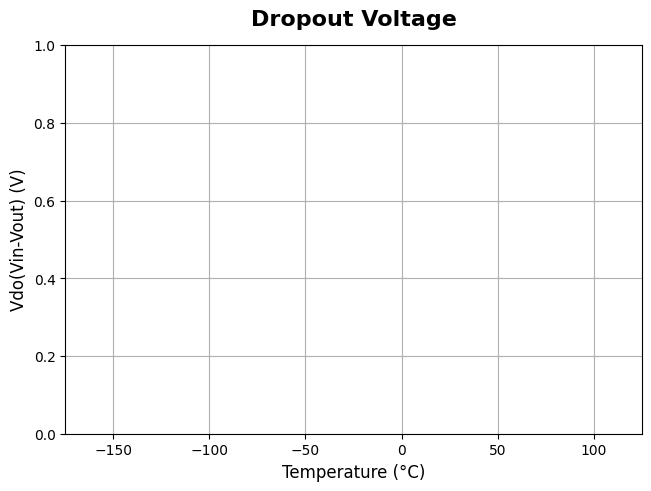

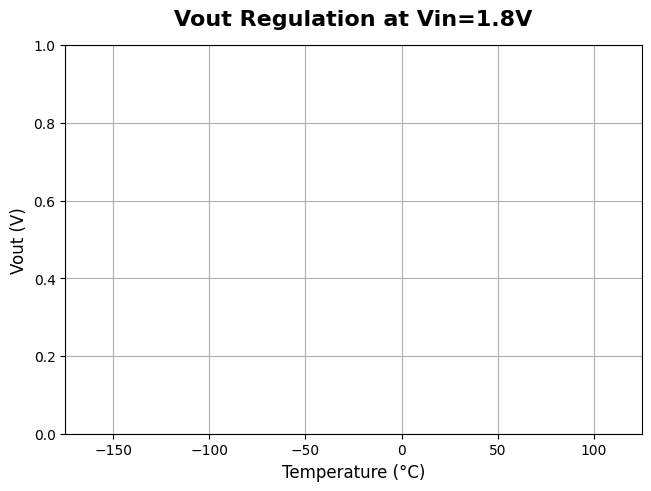

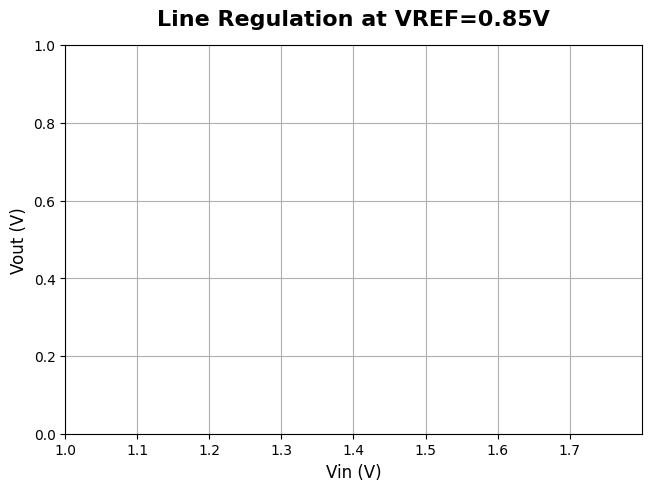

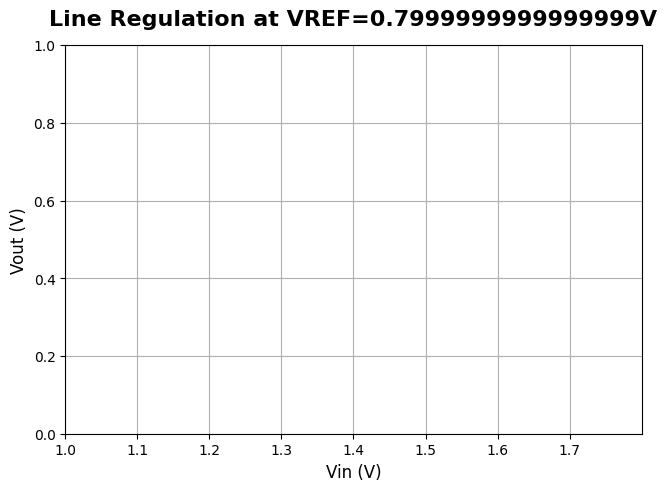

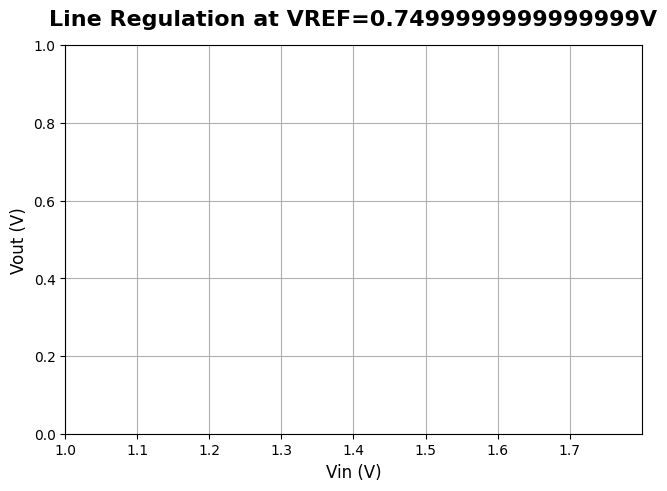

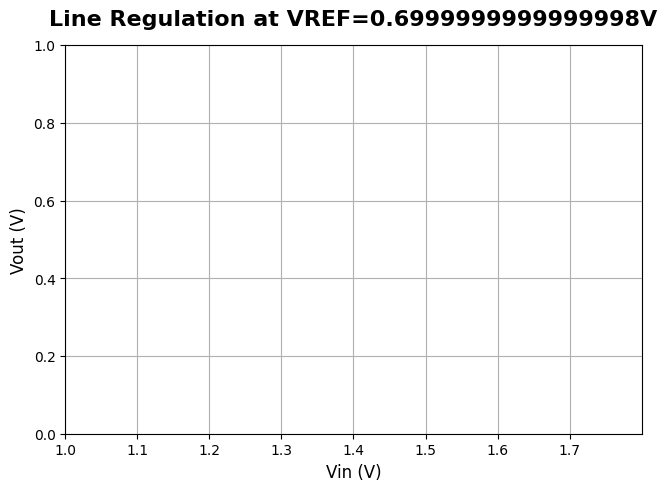

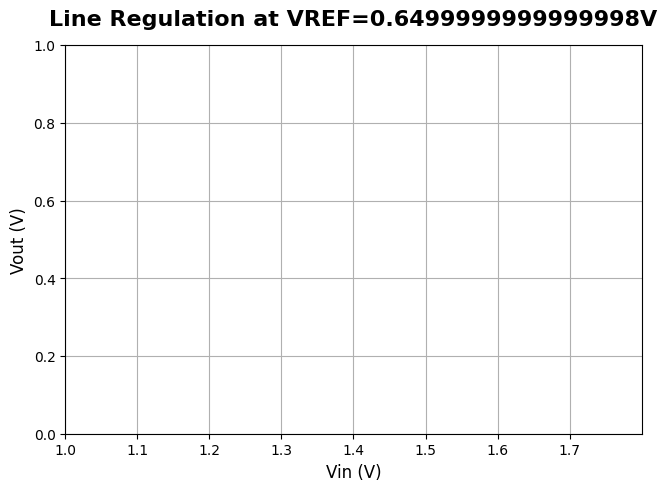

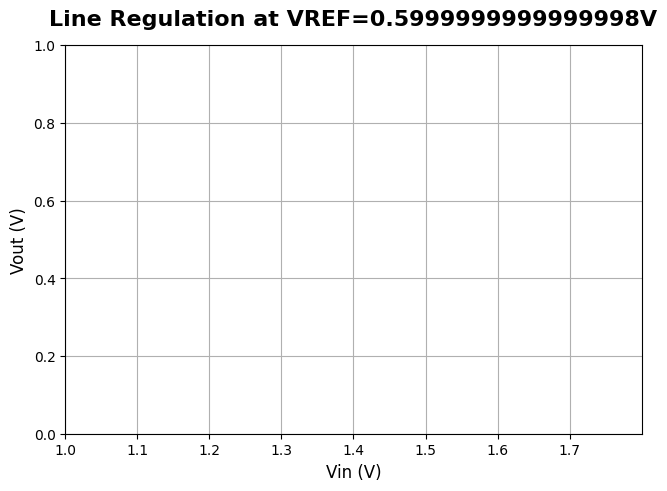

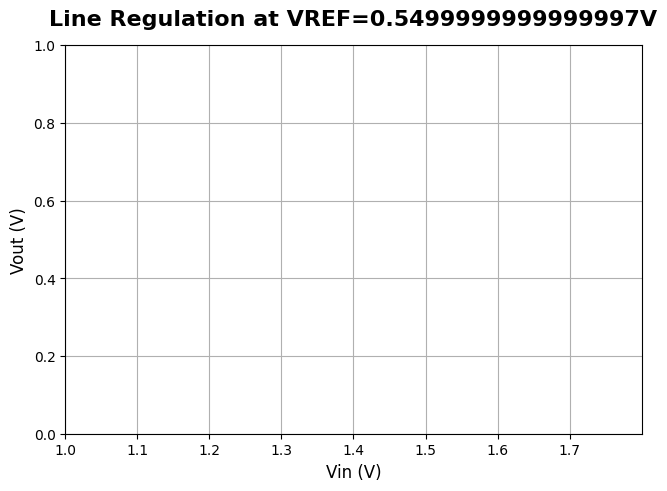

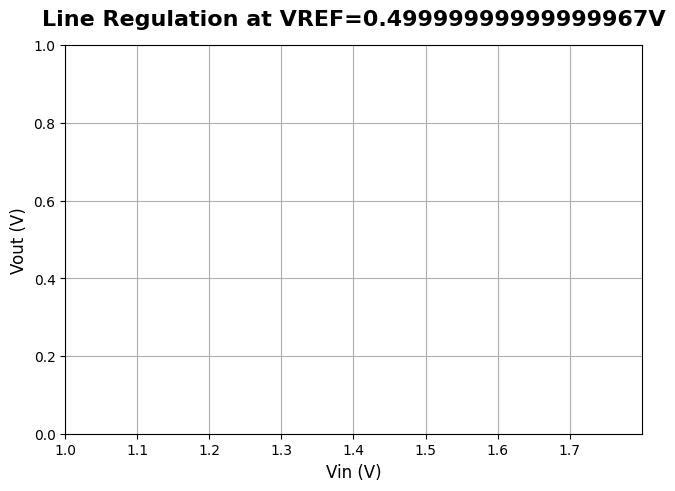

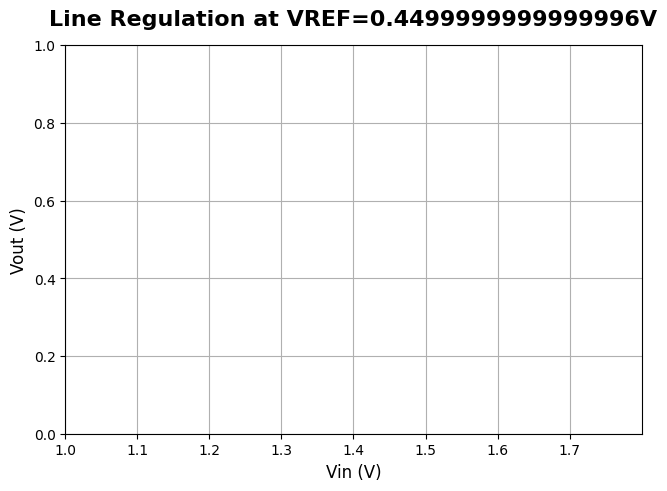

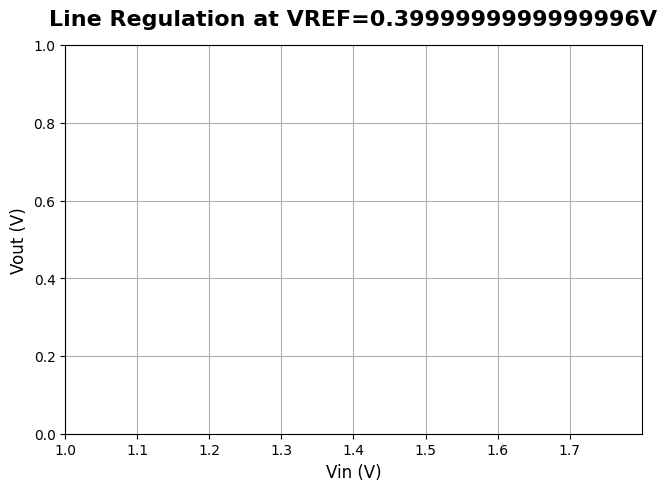

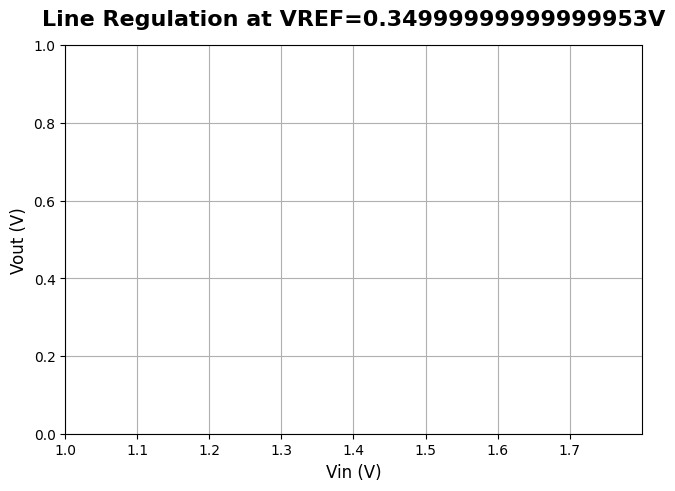

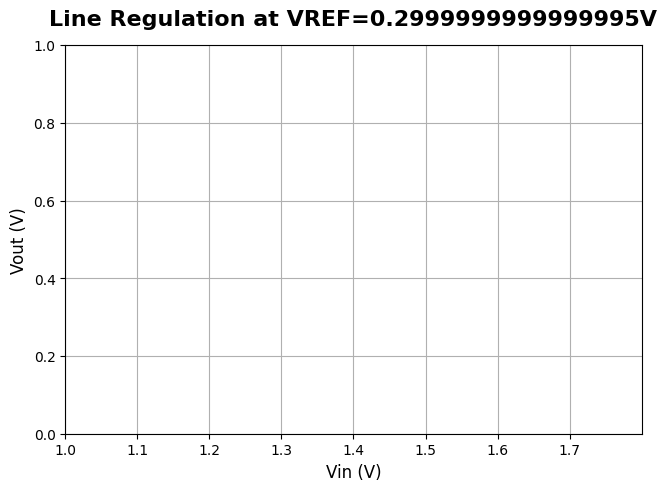

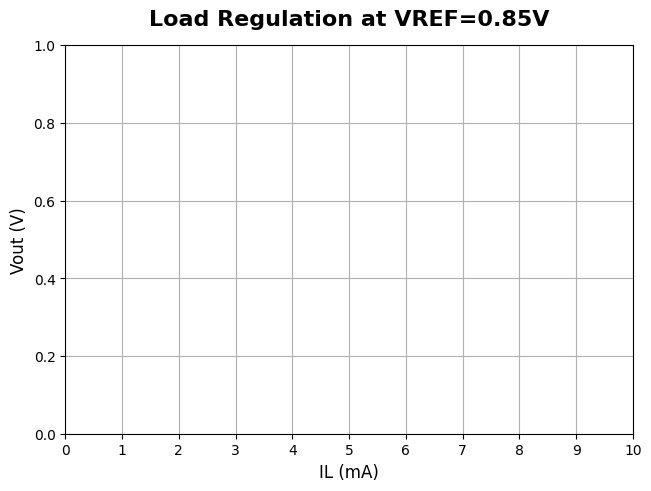

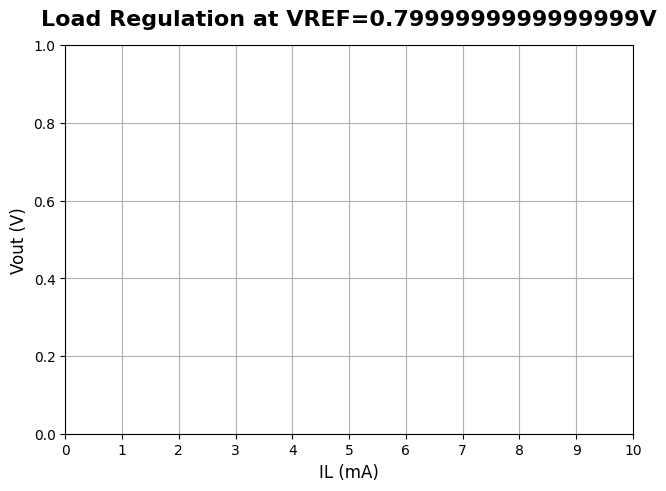

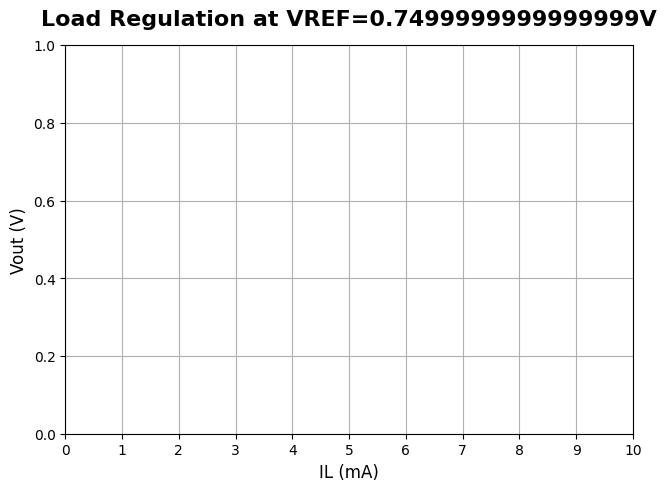

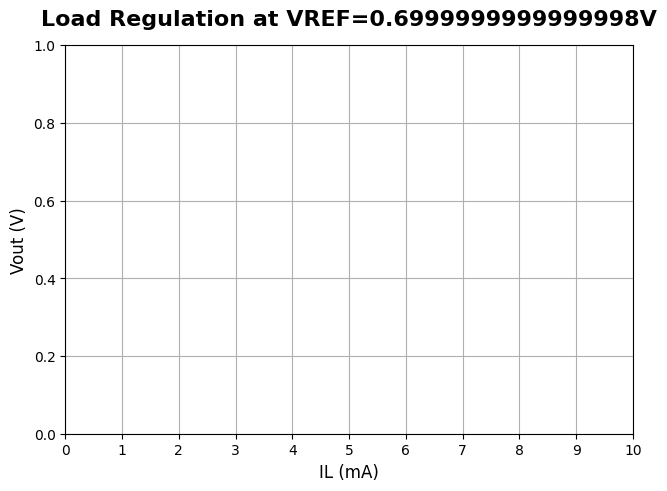

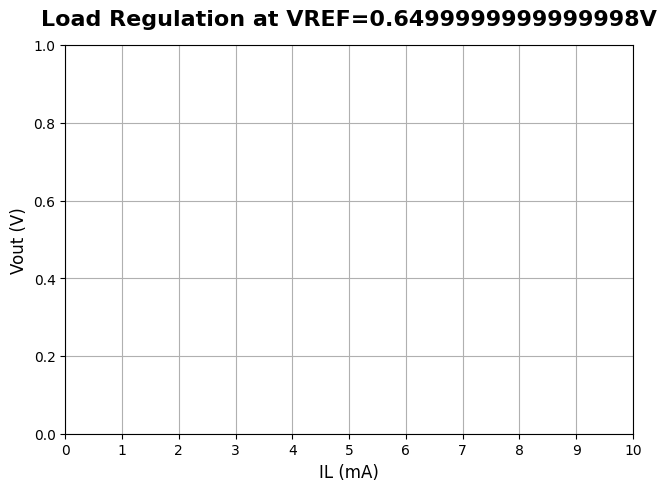

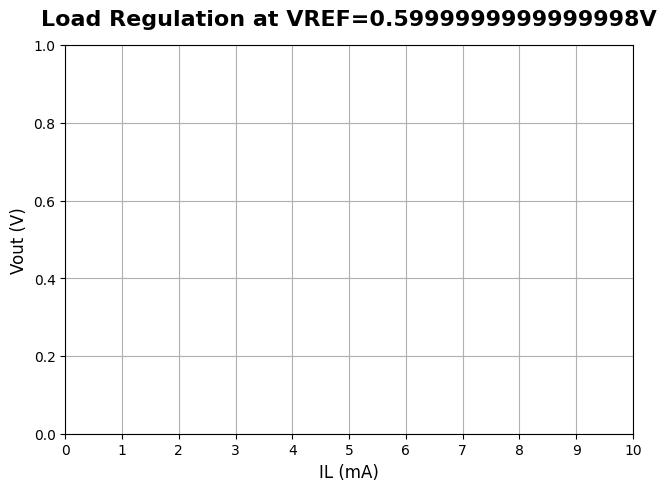

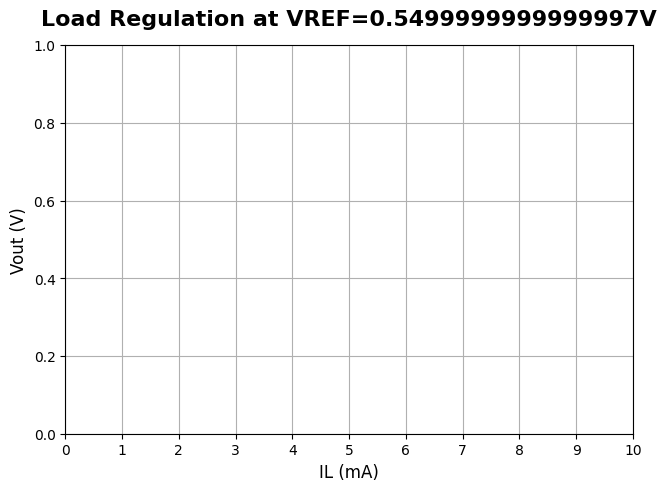

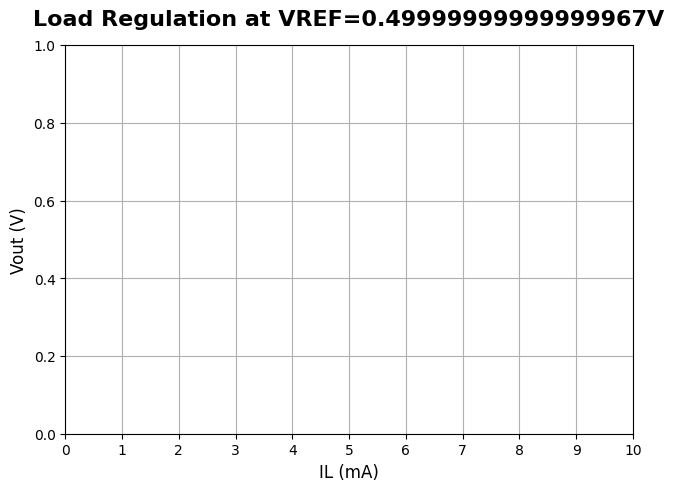

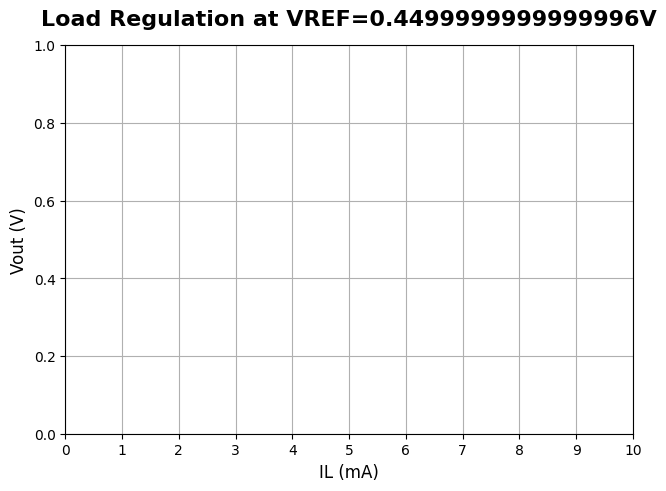

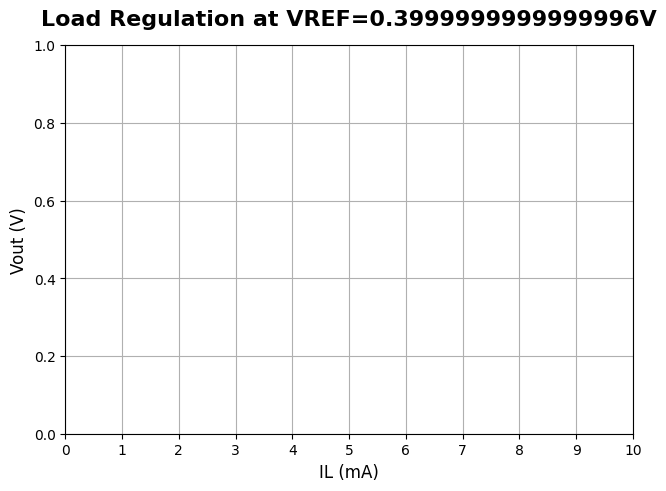

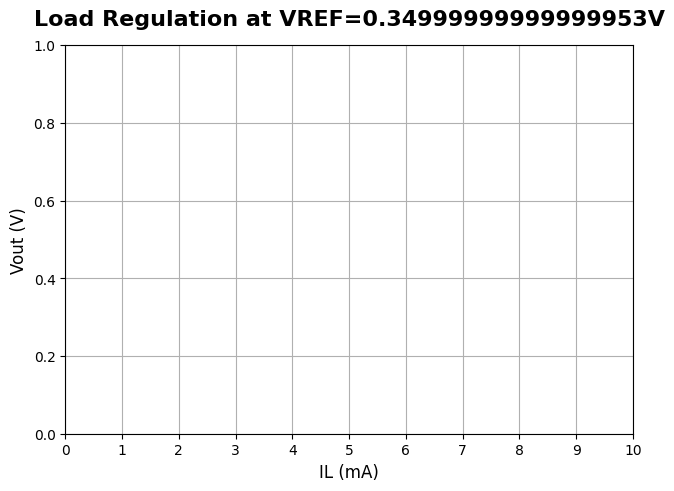

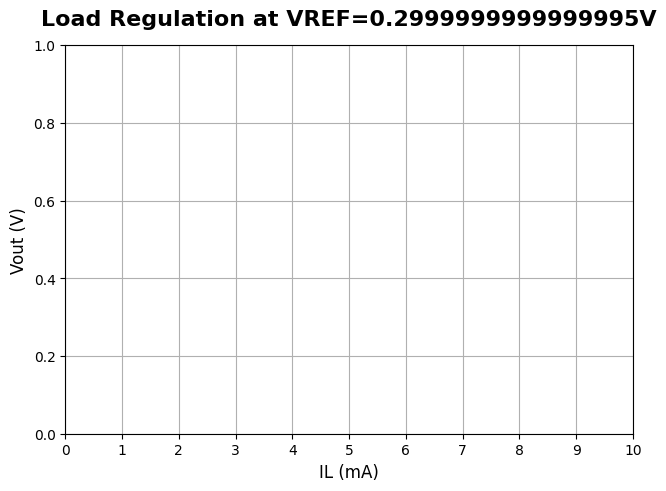

In [103]:
# PRACTICE Run, chamber stays at room temperature
Run_Experiment(False)

In [ ]:
#
#
# Buffer so we don't misclick
#
#

In [ ]:
# ACTUAL Run, chamber sweeps temperature
Run_Experiment(True)